# Sterren binnen 10 parsec van de zon

We gaan nu all sterren opvragen in de Gaia DR2 catalogus die zich op 10 parsec of minder van de zon bevinden dit betekent dat de parallax groter dan 10 mas moet zijn. 

## ADQL query

We gebruiken de volgende ADQL query:

```
 1 select source_id, ra, dec, parallax, pmra, pmdec, radial_velocity, phot_g_mean_mag, bp_rp
 2 from gaiadr2.gaia_source
 3 where 
 4 parallax >= 100
 5 and
 6 bp_rp is not null
 7 and
 8 (astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*exp(-0.4*(phot_g_mean_mag-19.5))
 9 or
10 astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1)
11 and
12 1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor
13 and
14 1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor
```

Dit ziet er wat ingewikkelder uit dan verwacht (we hoeven ten slotte alleen te selecteren op $\varpi>100$ mas). De query kan in de volgende stappen onderverdeeld worden:
* Regels 1 en 2 bevatten de instructie om uit het Gaia Archive de astrometrie en radi&euml;le snelheidsgegevens te halen. Er wordt ook gevraagd naar de schijnbare helderheid van de ster (`phot_g_mean_mag`) en de kleur (`bp_rp`) (daarover meer verderop in dit notebook).
* Regels 3 en 4 bevatten de voorwaarde dat de parallax groter dan 100 milli-boogseconden moet zijn
* De rest van de regels bevatten voorwaarden die ervoor zorgen dat we alleen betrouwbare gegevens uit de catalogus halen. Hiermee worden vooral sterren met foutieve parallax metingen weggefilterd.

Omdat we nu de gegevens van meerdere sterren opvragen en we wellicht meerdere analyses will doen met dezelfde gegevens is het handig om deze als tabel op onze eigen harde schijf op te slaan. Voer de query uit in het web interface van het Gaia Archive (geef hierbij de query een naam zoals in het plaatje te zien net boven de query)

<img src="./figuren/tenparsec-query.png" />

en klik vervolgens op het in het plaatje hierboven omcirkelde _download_ icoontje om de tabel te downloaden. De tabel wordt dan opgeslagen als `TienParsecSample-result.vot`. De tabel is voor de NWD workshop al klaargezet in de `data` folder (als `TienParsecSample.vot`) om zeker te zijn dat de gegevens beschikbaar zijn.

Standaard worden de tabellen opgeslagen in het zogenaamde Virtual Observatory Table (VOT) formaat, maar je kan andere data formaten voor de tabel kiezen met behulp van de boven omcirkelde keuze lijst (onderin plaatje). Bijvoorbeeld het CSV formaat is handig voor inlezen in Excel.

### ADQL Query in Python

De onderstaande code laat zien hoe de query in Python uitgevoerd kan worden

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astroquery.gaia import Gaia

from astropy.table import Table
import astropy.units as u
Av = (u.AU/u.yr).to(u.km/u.s)

In [27]:
querystring = """select source_id, ra, dec, parallax, pmra, pmdec, radial_velocity, phot_g_mean_mag, bp_rp 
from gaiadr2.gaia_source 
where 
parallax >= 100 
and 
bp_rp is not null
and 
(astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*exp(-0.4*(phot_g_mean_mag-19.5))
or 
astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1)
and 
1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor 
and 
1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor"""

jobtenpc = Gaia.launch_job_async(querystring, name="TienParsecSample", dump_to_file=False)

tienparsec_data = jobtenpc.get_results()

Query finished.


In [25]:
print(tienparsec_data.info)

<Table masked=True length=247>
      name       dtype    unit   format                            description                             n_bad
--------------- ------- -------- ------ ------------------------------------------------------------------ -----
      source_id   int64                 Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg {!r:>}                                                    Right ascension     0
            dec float64      deg {!r:>}                                                        Declination     0
       parallax float64      mas {!r:>}                                                           Parallax     0
           pmra float64 mas / yr {!r:>}                         Proper motion in right ascension direction     0
          pmdec float64 mas / yr {!r:>}                             Proper motion in declination direction     0
radial_velocity float64   km / s {!r:>}                          

Via de Python query kan de data ook opgeslagen worden door de regel `jobtenpc = ...` te vervangen door

```
jobtenpc = Gaia.launch_job_async(querystring, name="TienParsecSample", dump_to_file=True, \
                                 output_file="TienParsecSample.csv", output_format='csv')
```
waarbij hier gekozen is voor een tabel in CSV formaat.

## Visualisatie van de sterren binnen 10 parsec van de zon

De onderstaande code maakt gebruik van de opgeslagen tabel `TienParsecSample.vot` (in de `data` folder) en laat zien hoe je een plaatje van de 3D verdeling van de buursterren van de zon kunt maken met [matplotlib](https://matplotlib.org/).

Eerste lezen we de tabel met behulp van een toepassing (`Table`) uit het [Astropy](http://www.astropy.org/) pakket.

In [32]:
tienparsec_data = Table.read('./data/TienParsecSample.vot', format='votable')
print(tienparsec_data.info)

<Table masked=True length=247>
      name       dtype     unit    format                            description                             n_bad
--------------- ------- ---------- ------ ------------------------------------------------------------------ -----
      source_id   int64                   Unique source identifier (unique within a particular Data Release)     0
             ra float64        deg {!r:>}                                                    Right ascension     0
            dec float64        deg {!r:>}                                                        Declination     0
       parallax float64        mas {!r:>}                                                           Parallax     0
           pmra float64 mas.yr**-1 {!r:>}                         Proper motion in right ascension direction     0
          pmdec float64 mas.yr**-1 {!r:>}                             Proper motion in declination direction     0
radial_velocity float64   km.s**-1 {!r:>}        

Het volgende blok code laat zien hoe je de 3D posities van de 247 sterren in de table berekent. In Python kan dit zonder een "loop" constructie omdat berekeningen op hele kolommen in een tabel toegepast kunnen worden.

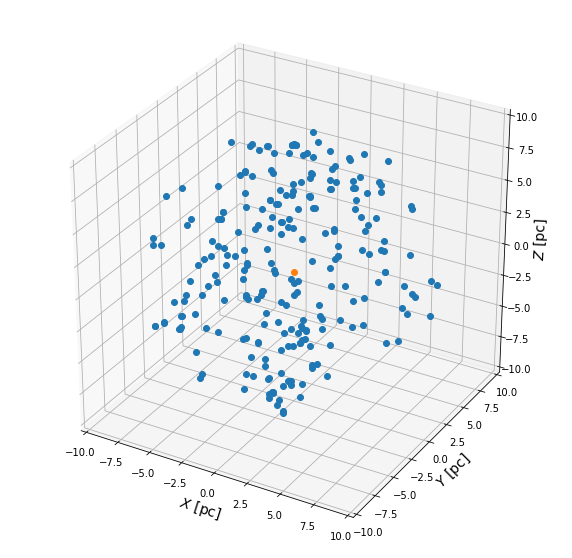

In [44]:
ra = tienparsec_data['ra']
dec = tienparsec_data['dec']
parallax = tienparsec_data['parallax']

p = [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]

x = p[0]*1000/parallax
y = p[1]*1000/parallax
z = p[2]*1000/parallax

fig = plt.figure(figsize=(10,10))
axpos = fig.add_subplot(1, 1, 1, projection='3d')

axpos.plot(x, y, z, 'o')
axpos.plot([0], [0], [0], 'o')
axpos.set_xlim(-10,10)
axpos.set_ylim(-10,10)
axpos.set_zlim(-10,10)
axpos.set_xlabel(r'$X$ [pc]', fontsize=14)
axpos.set_ylabel(r'$Y$ [pc]', fontsize=14)
axpos.set_zlabel(r'$Z$ [pc]', fontsize=14)

plt.show()